In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Setting up plot style
plt.style.use('seaborn')
sns.set_palette("deep")

2024-09-09 10:08:42.800707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_15204/2181362577.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Loan Default Prediction Project
## 1. Introduction
In this project, we aim to develop a predictive model to identify loan applicants with an acceptable probability of default. This model will be used in the credit origination process to assist in decision-making regarding loan approvals.
## 2. Data Loading and Initial Exploration
Let's start by loading the dataset and performing some initial exploratory data analysis.

In [2]:
# Load the dataset
data = pd.read_csv("Credit_Data.csv")
del data['OBS#']

# Display basic information about the dataset
print(data.info())

# Display the first few rows of the dataset
print(data.head())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   CHK_ACCT          1000 non-null   int64
 1   DURATION          1000 non-null   int64
 2   HISTORY           1000 non-null   int64
 3   NEW_CAR           1000 non-null   int64
 4   USED_CAR          1000 non-null   int64
 5   FURNITURE         1000 non-null   int64
 6   RADIO/TV          1000 non-null   int64
 7   EDUCATION         1000 non-null   int64
 8   RETRAINING        1000 non-null   int64
 9   AMOUNT            1000 non-null   int64
 10  SAV_ACCT          1000 non-null   int64
 11  EMPLOYMENT        1000 non-null   int64
 12  INSTALL_RATE      1000 non-null   int64
 13  MALE_DIV          1000 non-null   int64
 14  MALE_SINGLE       1000 non-null   int64
 15  MALE_MAR_or_WID   1000 non-null   int64
 16  CO-APPLICANT      1000 non-null   int64
 17  GUARANTOR         1000 non-null   

# 3. Data Preprocessing
# 3.1 Handling Missing Values

In [3]:
# Check for missing values
print(data.isnull().sum())

# As per the data description, there are no missing values.

CHK_ACCT            0
DURATION            0
HISTORY             0
NEW_CAR             0
USED_CAR            0
FURNITURE           0
RADIO/TV            0
EDUCATION           0
RETRAINING          0
AMOUNT              0
SAV_ACCT            0
EMPLOYMENT          0
INSTALL_RATE        0
MALE_DIV            0
MALE_SINGLE         0
MALE_MAR_or_WID     0
CO-APPLICANT        0
GUARANTOR           0
PRESENT_RESIDENT    0
REAL_ESTATE         0
PROP_UNKN_NONE      0
AGE                 0
OTHER_INSTALL       0
RENT                0
OWN_RES             0
NUM_CREDITS         0
JOB                 0
NUM_DEPENDENTS      0
TELEPHONE           0
FOREIGN             0
DEFAULT             0
dtype: int64


# 4. Exploratory Data Analysis (EDA)
## 4.1 Distribution of Target Variable

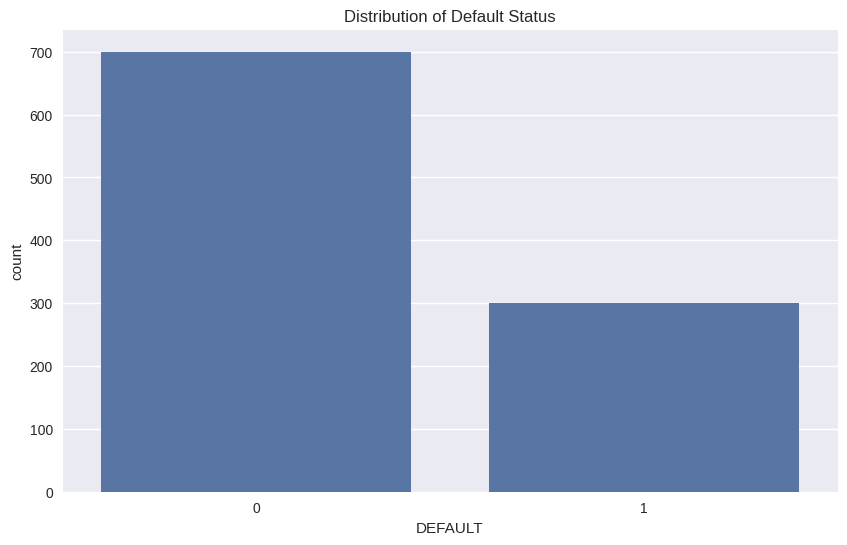

DEFAULT
0    0.7
1    0.3
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='DEFAULT', data=data)
plt.title('Distribution of Default Status')
plt.show()

print(data['DEFAULT'].value_counts(normalize=True))

## 4.2 Correlation Analysis

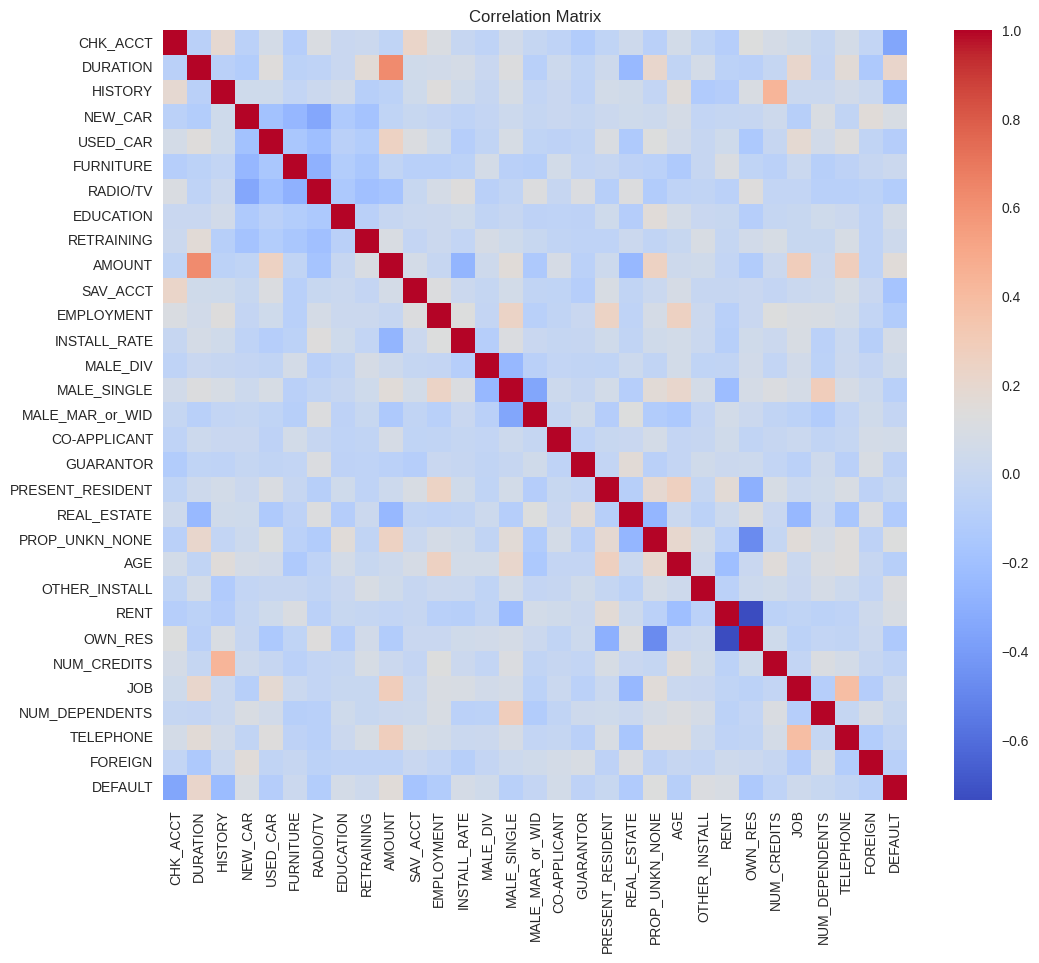

In [5]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 4.3 Principal Component Analysis

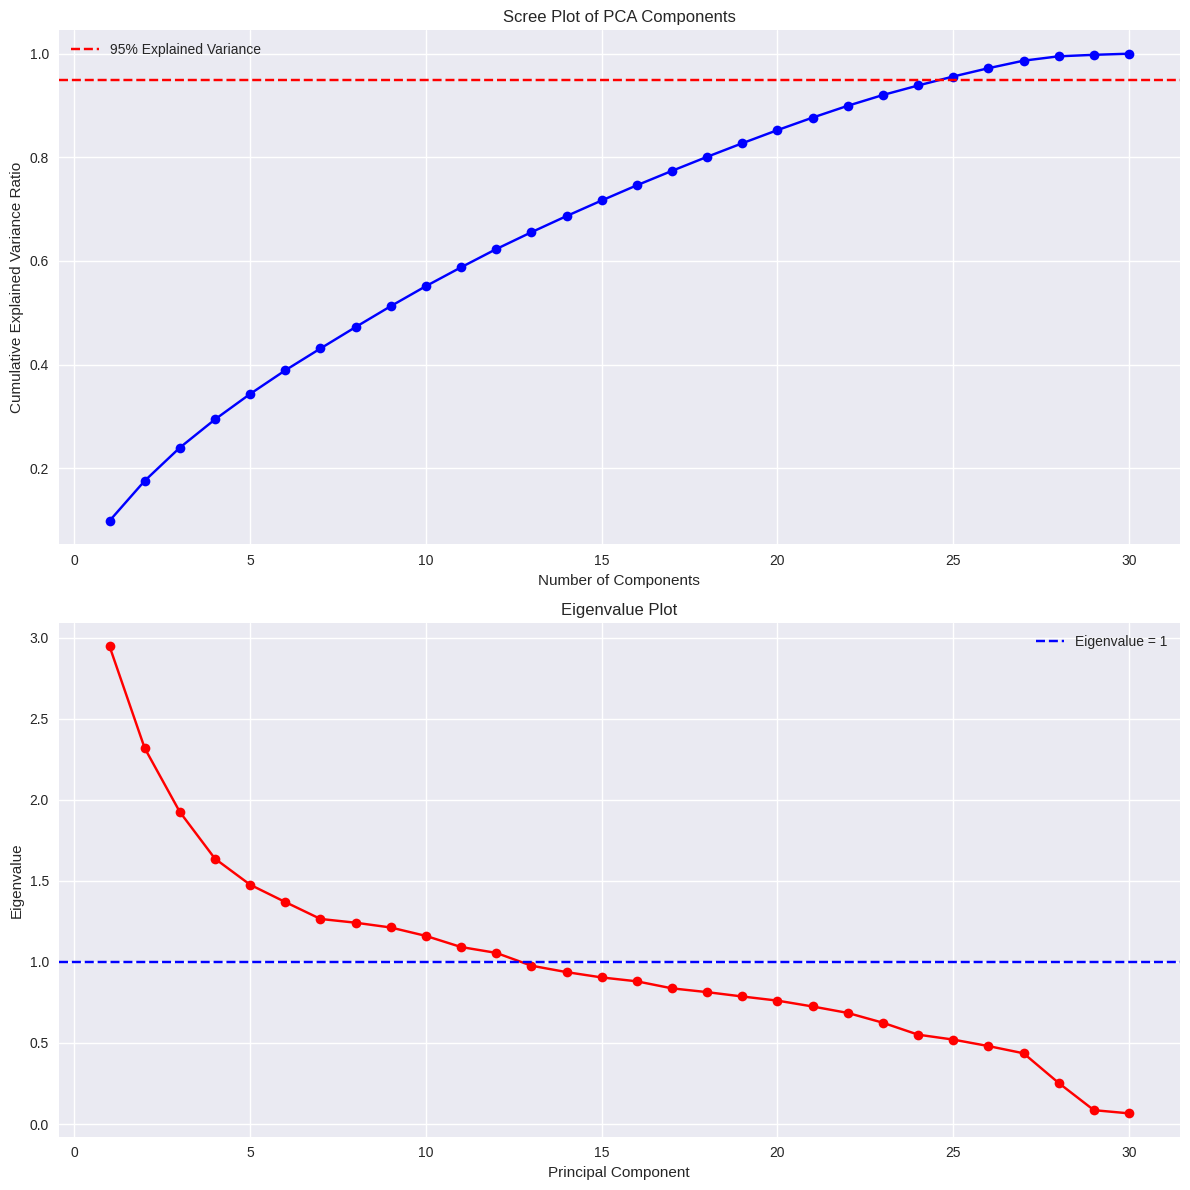


Number of components explaining 95% of variance: 25
Number of components with eigenvalue > 1: 12


In [6]:
# 17. Principal Component Analysis (PCA)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('DEFAULT', axis=1))

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(data_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Scree plot
ax1.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio, 'bo-')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance Ratio')
ax1.set_title('Scree Plot of PCA Components')
ax1.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
ax1.legend()

# Eigenvalue plot
eigenvalues = pca.explained_variance_
ax2.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'ro-')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Eigenvalue')
ax2.set_title('Eigenvalue Plot')
ax2.axhline(y=1, color='b', linestyle='--', label='Eigenvalue = 1')
ax2.legend()

plt.tight_layout()
plt.show()

# Find number of components for 95% variance explained
n_components_95 = next(i for i, ratio in enumerate(cumulative_variance_ratio) if ratio >= 0.95) + 1
print(f"\nNumber of components explaining 95% of variance: {n_components_95}")

# Find number of components with eigenvalue > 1
n_components_eigen1 = sum(eigenvalues > 1)
print(f"Number of components with eigenvalue > 1: {n_components_eigen1}")

## 4.4 Numerical Features Analysis

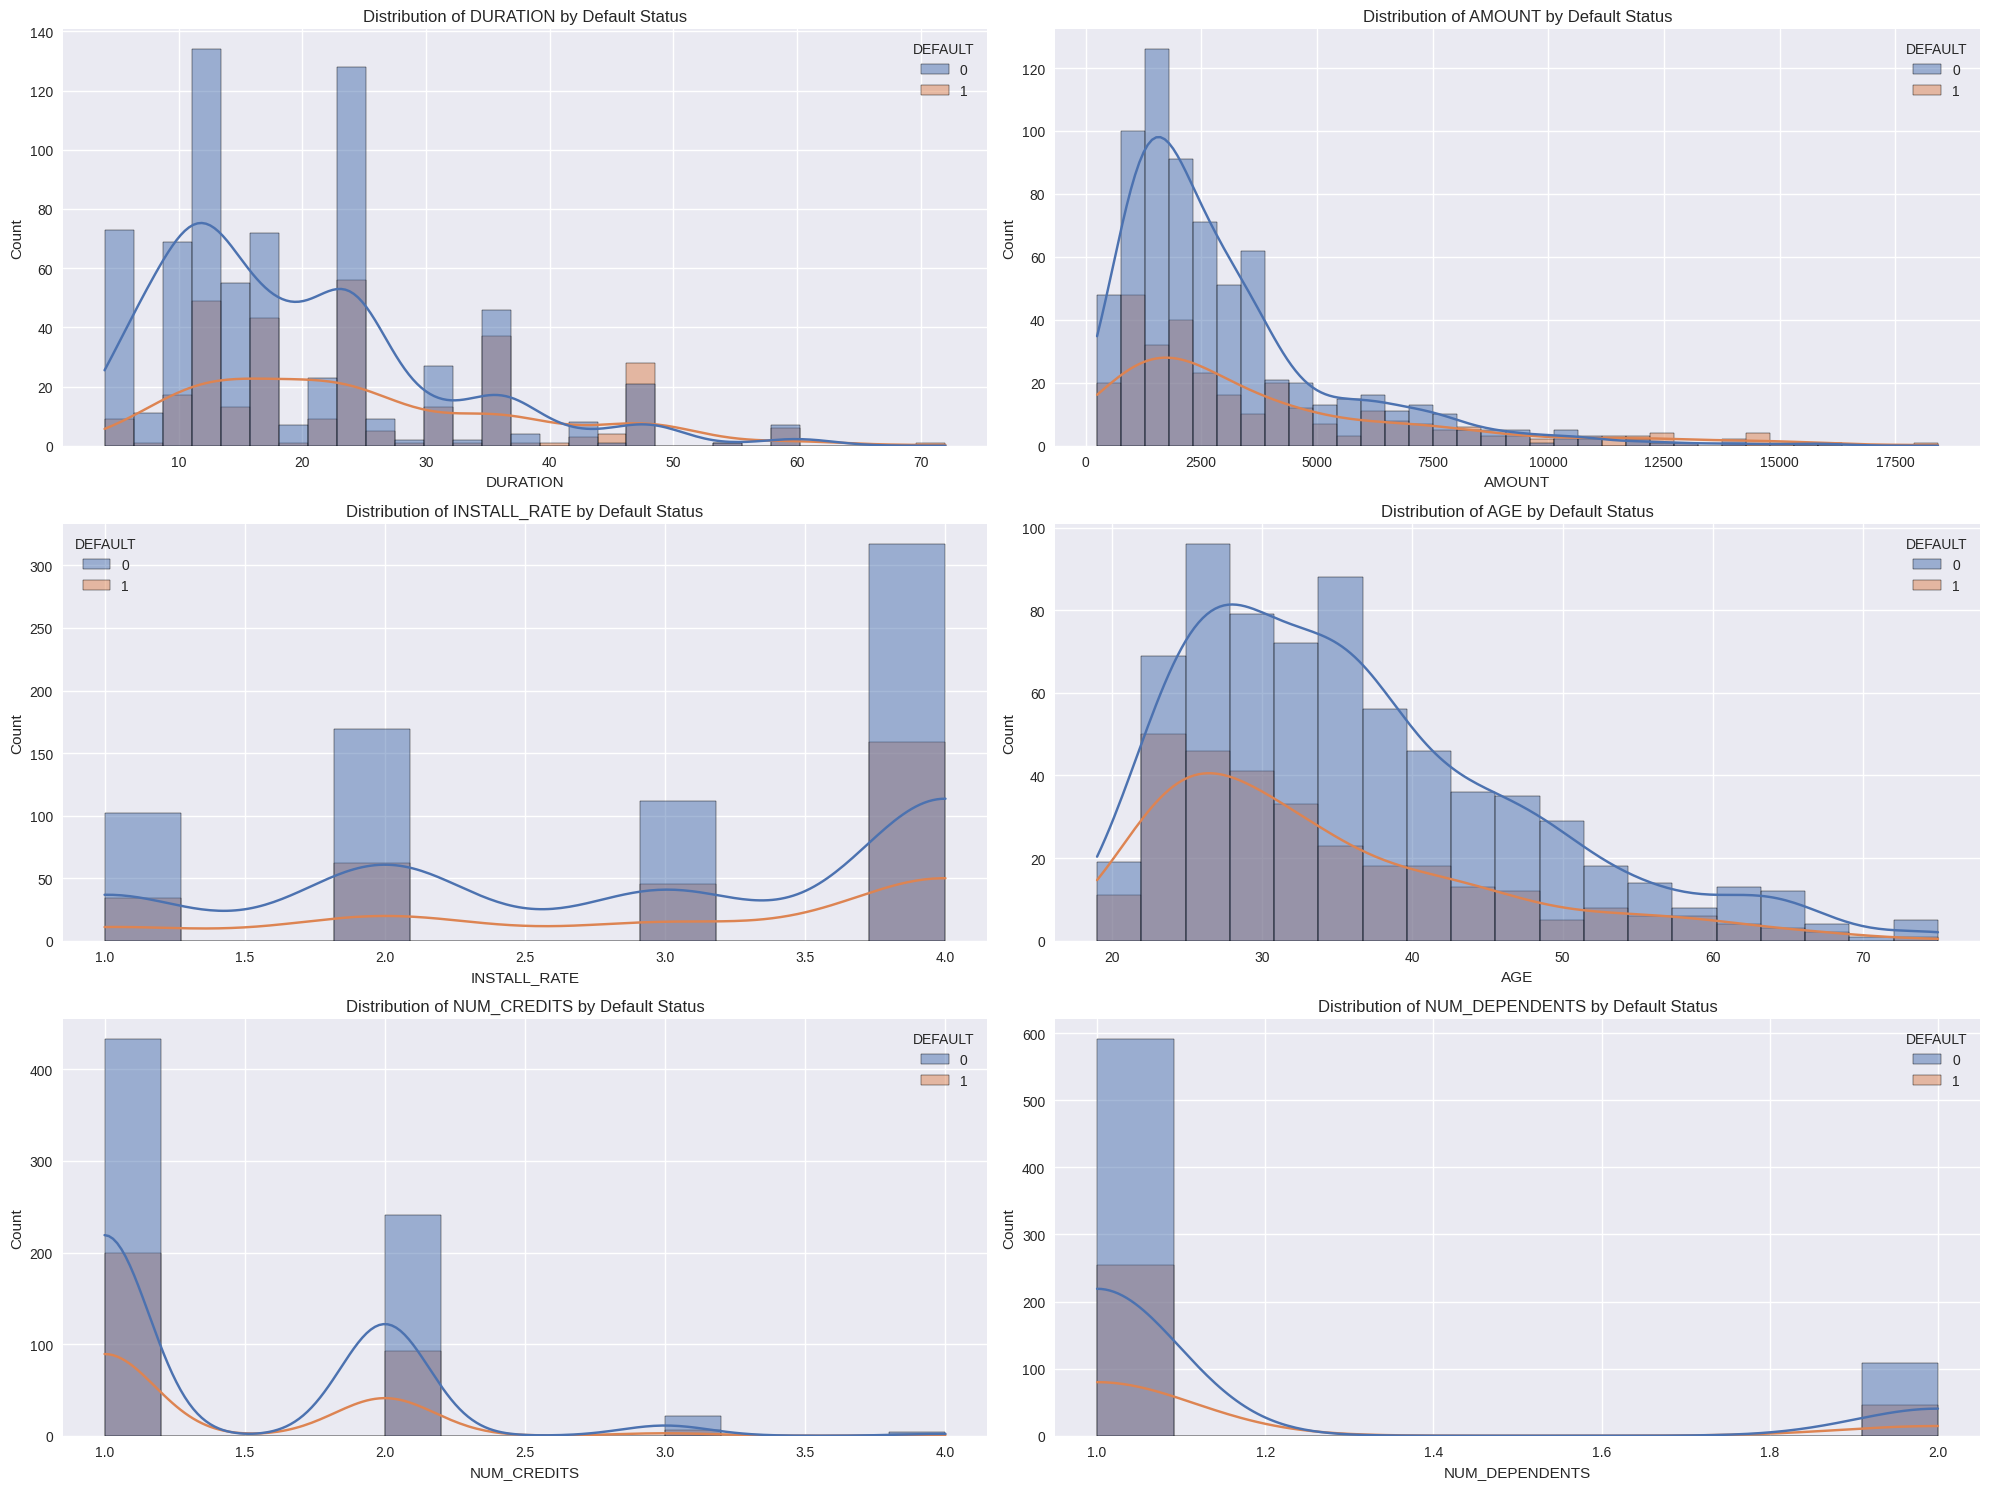

In [7]:
numerical_features = ['DURATION', 'AMOUNT', 'INSTALL_RATE', 'AGE', 'NUM_CREDITS', 'NUM_DEPENDENTS']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=data, x=feature, hue='DEFAULT', kde=True)
    plt.title(f'Distribution of {feature} by Default Status')
plt.tight_layout()
plt.show()

## 4.5 Categorical Features Analysis

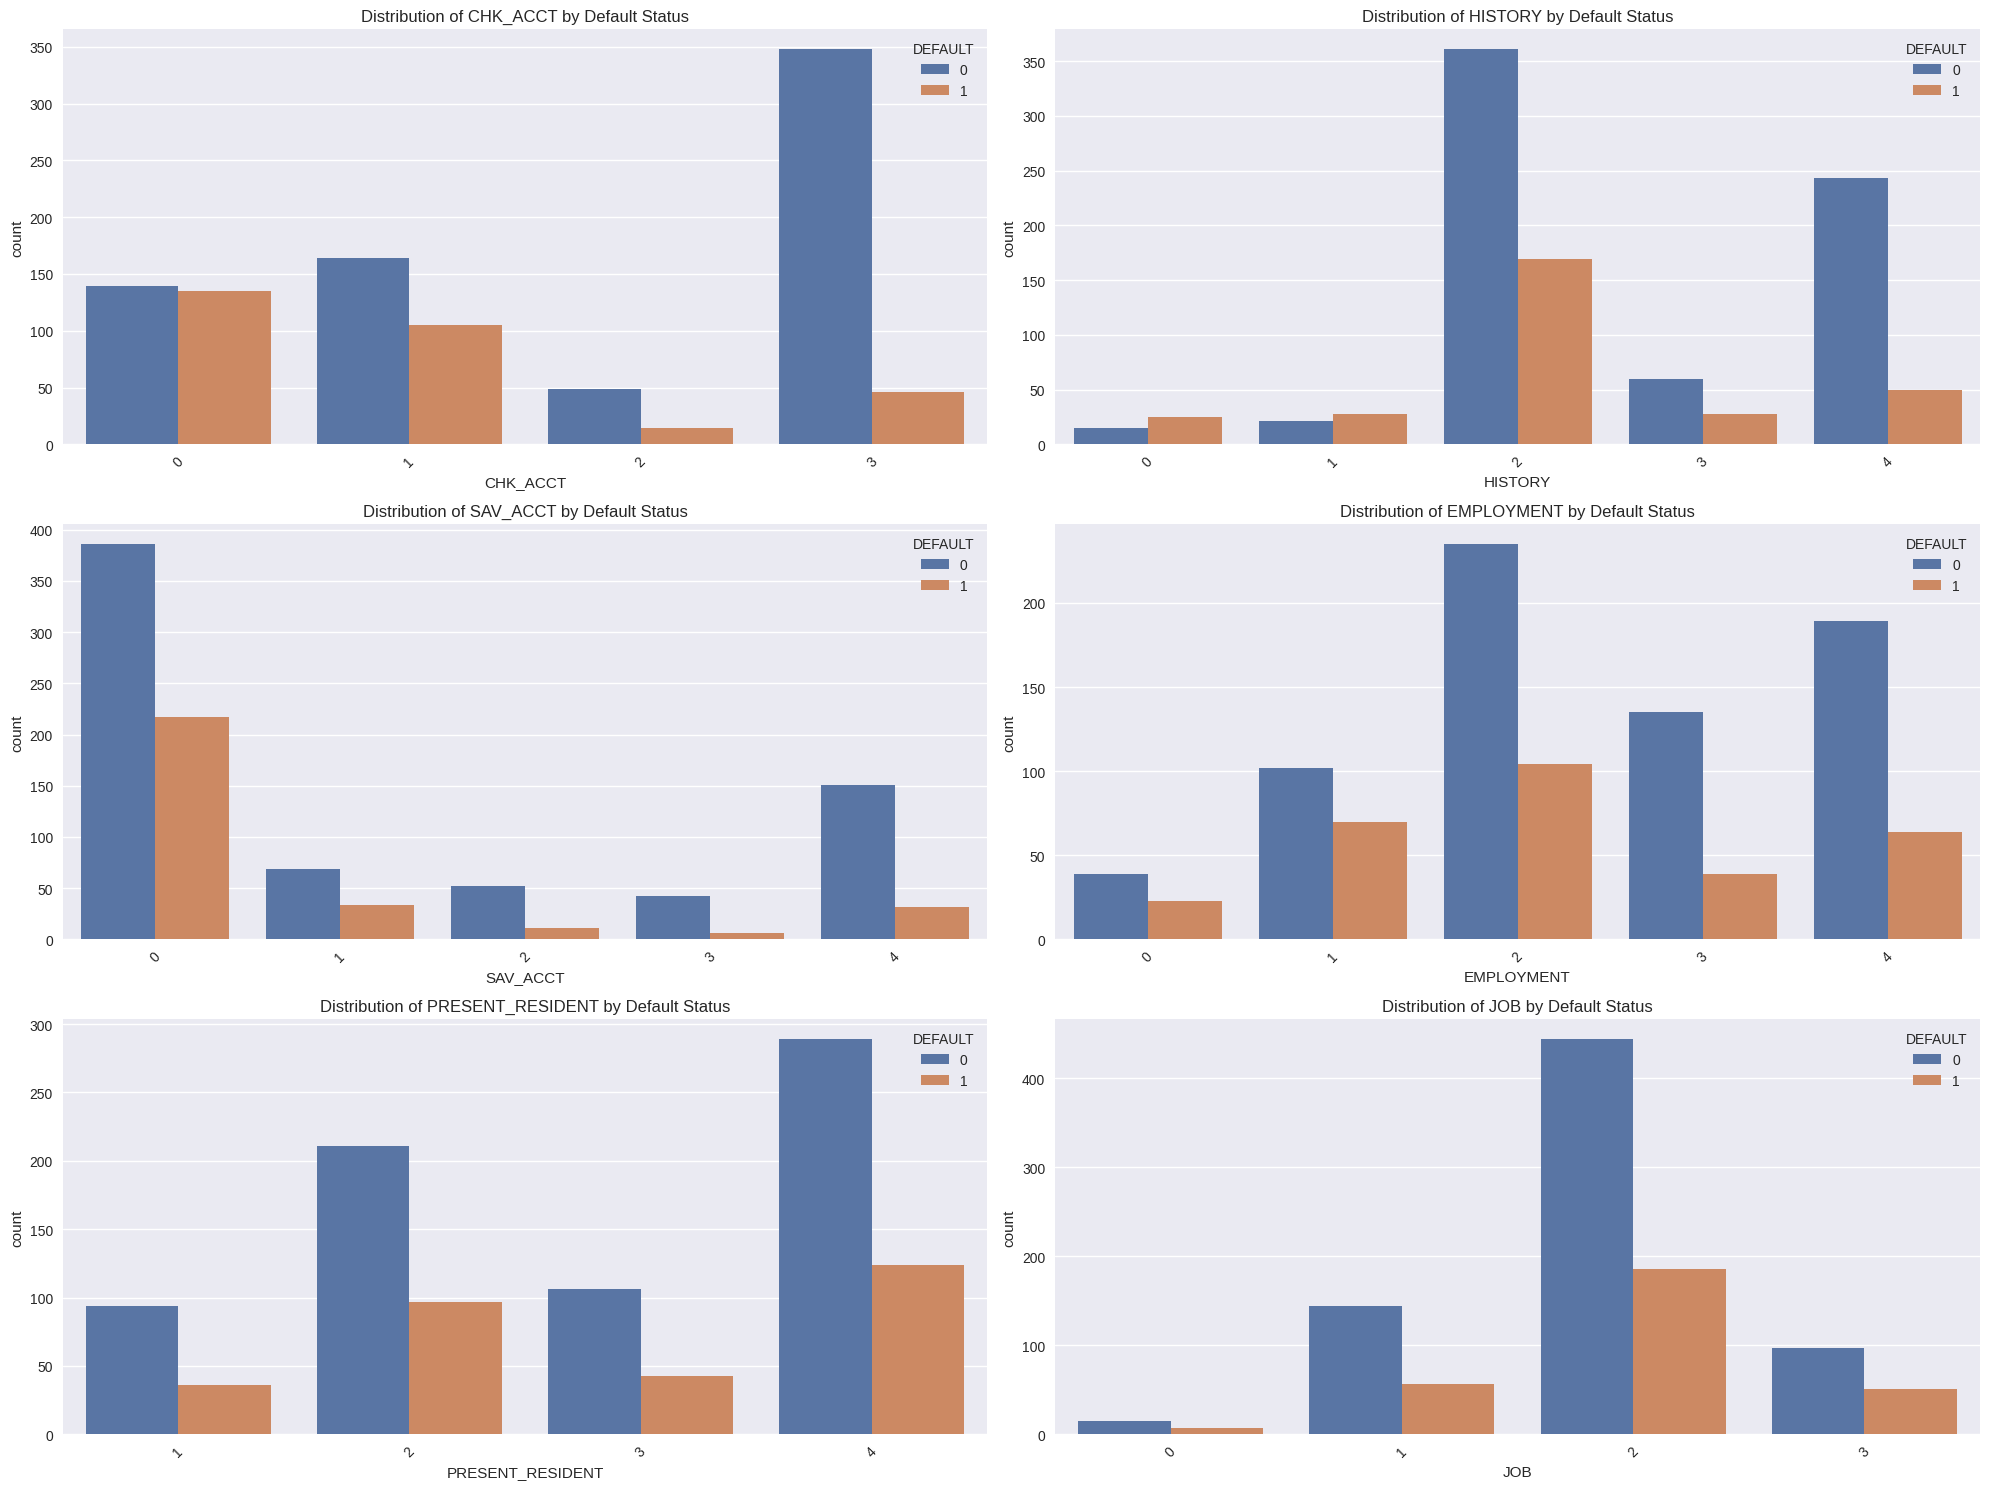

In [8]:
categorical_features = ['CHK_ACCT', 'HISTORY', 'SAV_ACCT', 'EMPLOYMENT', 'PRESENT_RESIDENT', 'JOB']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=data, x=feature, hue='DEFAULT')
    plt.title(f'Distribution of {feature} by Default Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4.6 Age-based Analysis

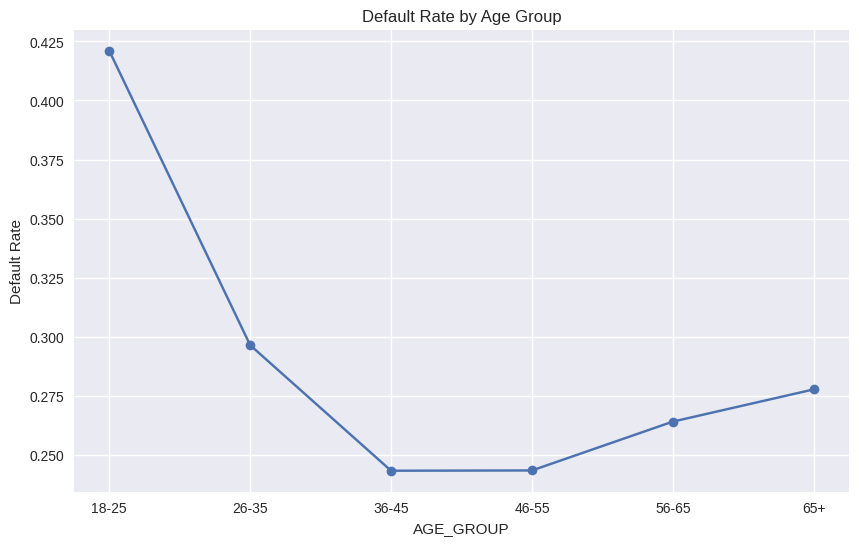

In [9]:
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

plt.figure(figsize=(10, 6))
data.groupby('AGE_GROUP')['DEFAULT'].mean().plot(kind='line', marker='o')
plt.title('Default Rate by Age Group')
plt.ylabel('Default Rate')
plt.show()

## 4.7 Loan Amount Analysis

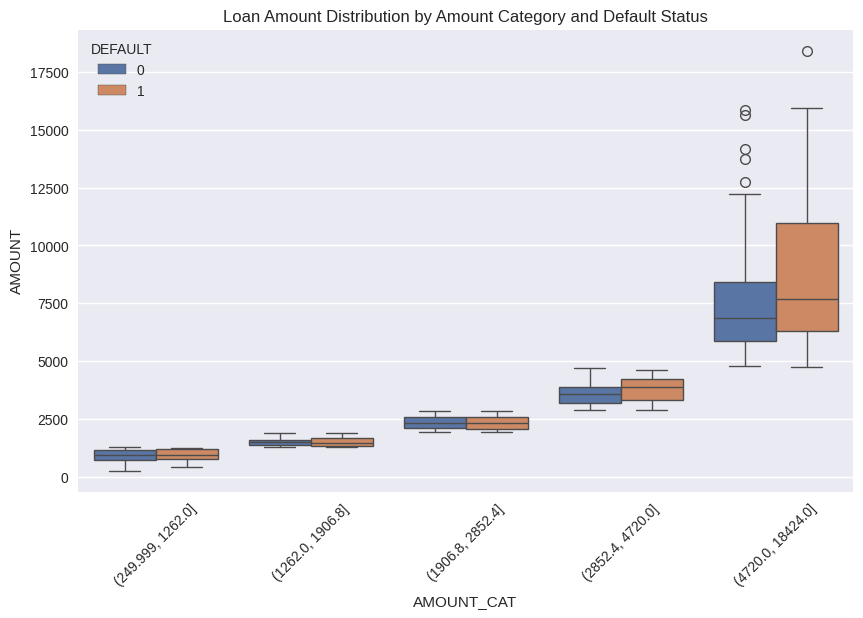

In [10]:
data['AMOUNT_CAT'] = pd.qcut(data['AMOUNT'], q=5)

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='AMOUNT_CAT', y='AMOUNT', hue='DEFAULT')
plt.title('Loan Amount Distribution by Amount Category and Default Status')
plt.xticks(rotation=45)
plt.show()

## 4.8 Credit History Impact

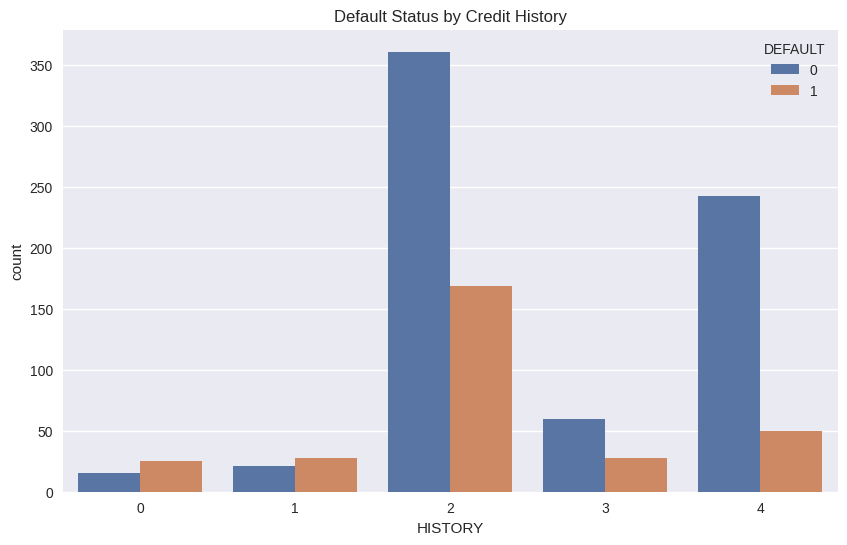

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='HISTORY', hue='DEFAULT')
plt.title('Default Status by Credit History')
plt.show()

## 4.9 Employment and Income Stability

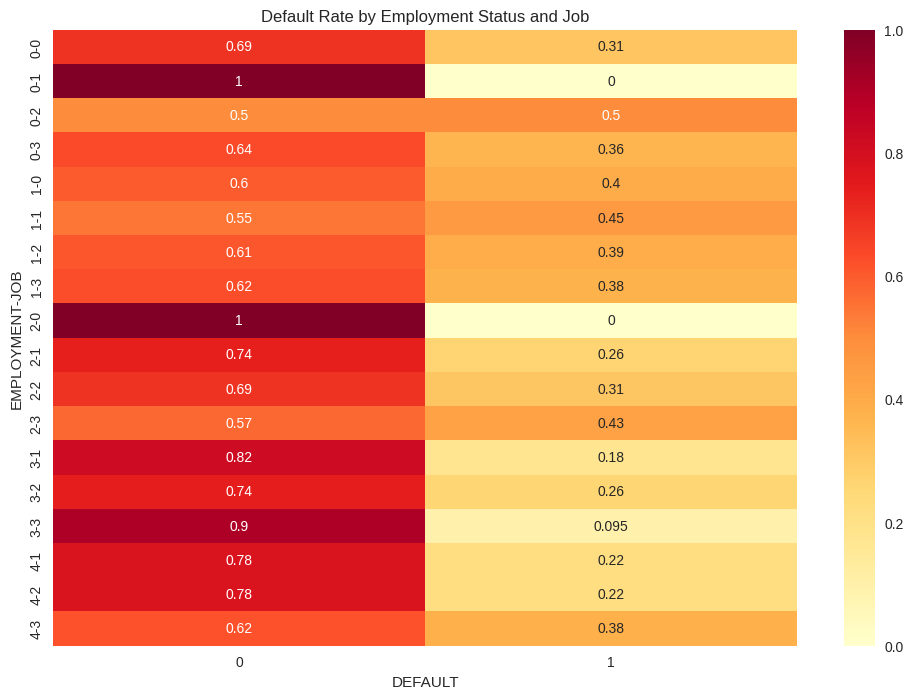

In [12]:
plt.figure(figsize=(12, 8))
employment_job_default = pd.crosstab([data['EMPLOYMENT'], data['JOB']], data['DEFAULT'], normalize='index')
sns.heatmap(employment_job_default, annot=True, cmap='YlOrRd')
plt.title('Default Rate by Employment Status and Job')
plt.show()

## 4.10 Purpose of Loan Analysis

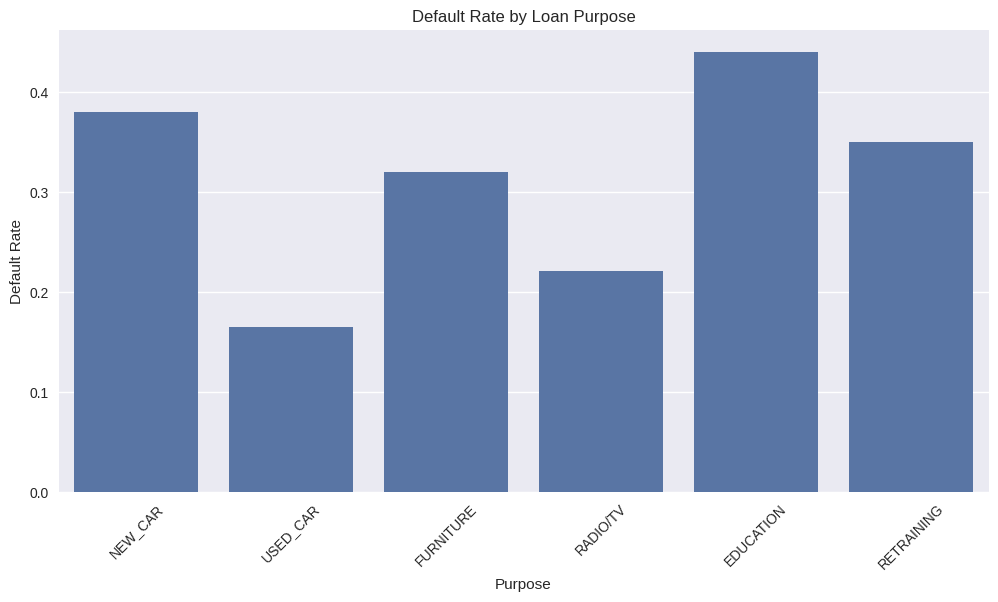

In [13]:
purpose_cols = ['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO/TV', 'EDUCATION', 'RETRAINING']
purpose_default_rates = data[purpose_cols + ['DEFAULT']].groupby(purpose_cols).mean().reset_index()
purpose_default_rates = purpose_default_rates.melt(id_vars=['DEFAULT'], var_name='Purpose', value_name='Has_Purpose')
purpose_default_rates = purpose_default_rates[purpose_default_rates['Has_Purpose'] == 1]

plt.figure(figsize=(12, 6))
sns.barplot(data=purpose_default_rates, x='Purpose', y='DEFAULT')
plt.title('Default Rate by Loan Purpose')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()

## 4.11 Property Ownership Analysis

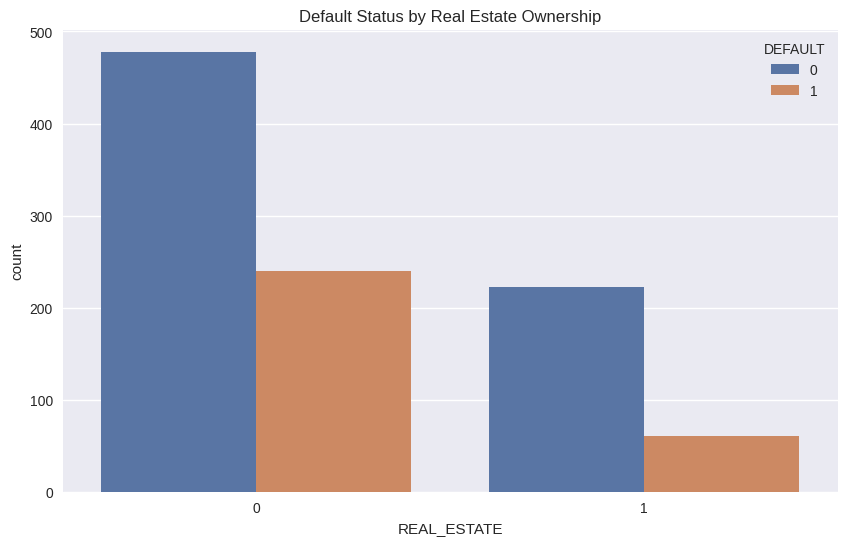

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='REAL_ESTATE', hue='DEFAULT')
plt.title('Default Status by Real Estate Ownership')
plt.show()

## 4.12 Marital Status and Gender Analysis

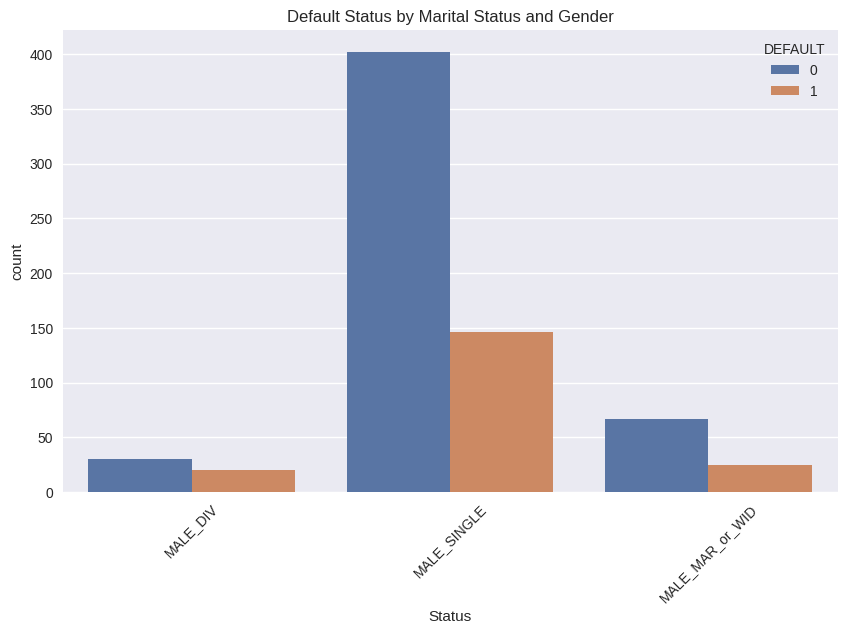

In [15]:
marital_gender_cols = ['MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID']
marital_gender_default = data[marital_gender_cols + ['DEFAULT']].melt(id_vars=['DEFAULT'], var_name='Status', value_name='Is_Status')
marital_gender_default = marital_gender_default[marital_gender_default['Is_Status'] == 1]

plt.figure(figsize=(10, 6))
sns.countplot(data=marital_gender_default, x='Status', hue='DEFAULT')
plt.title('Default Status by Marital Status and Gender')
plt.xticks(rotation=45)
plt.show()

## 4.13 Co-applicant and Guarantor Impact

<Figure size 1200x600 with 0 Axes>

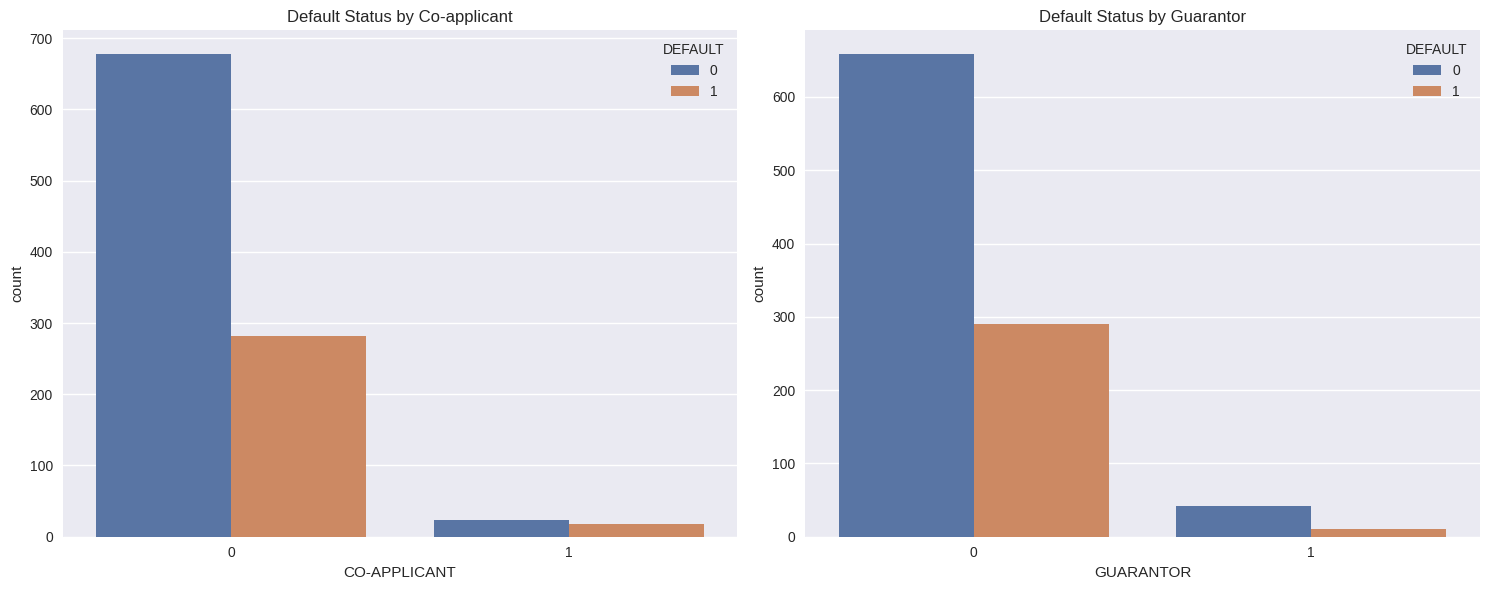

In [16]:
plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(data=data, x='CO-APPLICANT', hue='DEFAULT', ax=ax1)
ax1.set_title('Default Status by Co-applicant')
sns.countplot(data=data, x='GUARANTOR', hue='DEFAULT', ax=ax2)
ax2.set_title('Default Status by Guarantor')
plt.tight_layout()
plt.show()

## 4.14 Multiple Credits Analysis

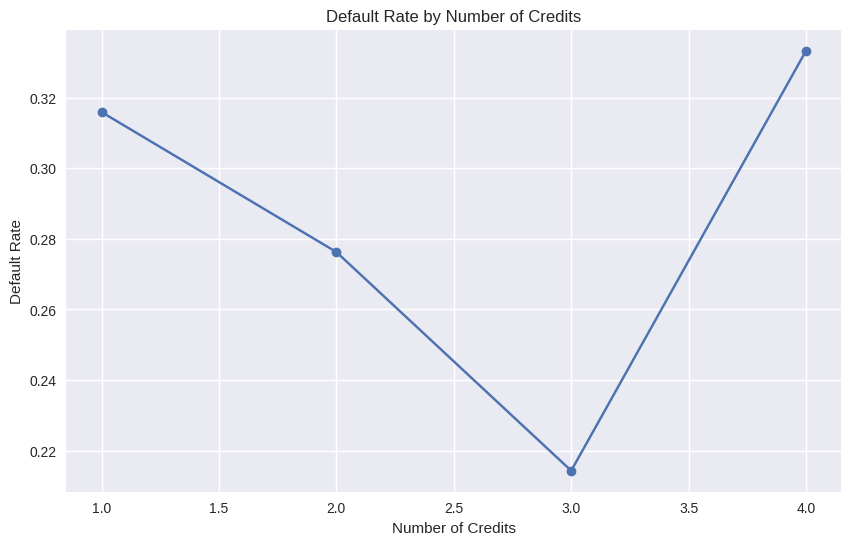

In [17]:
plt.figure(figsize=(10, 6))
data.groupby('NUM_CREDITS')['DEFAULT'].mean().plot(kind='line', marker='o')
plt.title('Default Rate by Number of Credits')
plt.ylabel('Default Rate')
plt.xlabel('Number of Credits')
plt.show()

## 4.15 Foreign Worker Analysis

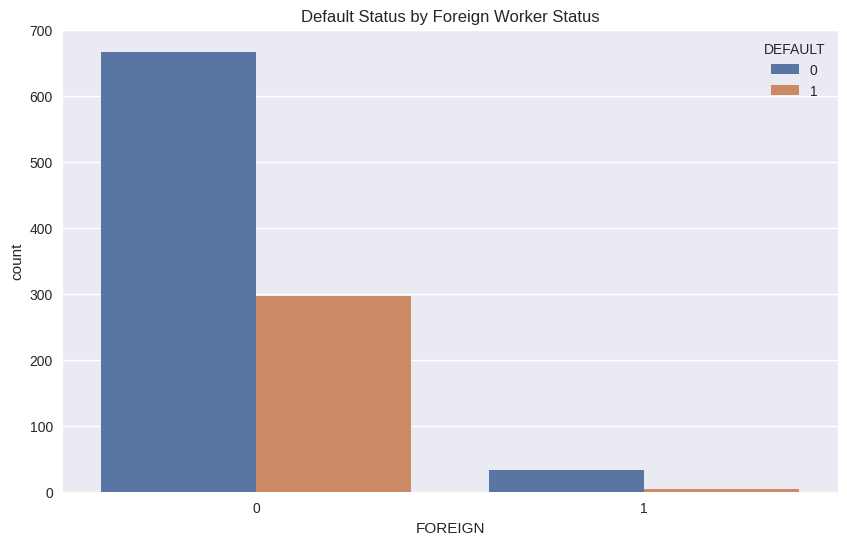

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='FOREIGN', hue='DEFAULT')
plt.title('Default Status by Foreign Worker Status')
plt.show()

# 5. Feature Engineering and Preprocessing

In [19]:
# Create a weighted encoding for CHK_ACCT: Custom encoding that assigns higher weights to better checking account statuses
chk_acct_weights = {3: 0, 0: 1, 1: 2, 2: 4}
data['CHK_ACCT_WEIGHTED'] = data['CHK_ACCT'].map(chk_acct_weights)

# Create interaction features
data['CHK_ACCT_DURATION'] = data['CHK_ACCT_WEIGHTED'] * data['DURATION']
data['CHK_ACCT_AMOUNT'] = data['CHK_ACCT_WEIGHTED'] * data['AMOUNT']
data['CHK_ACCT_AGE'] = data['CHK_ACCT_WEIGHTED'] * data['AGE']

# Create a binary feature for having a checking account
data['HAS_CHK_ACCT'] = (data['CHK_ACCT'] != 3).astype(int)
# Create an ordinal feature representing the account balance level
data['CHK_ACCT_LEVEL'] = data['CHK_ACCT'].map({3: 0, 0: 1, 1: 2, 2: 3})

df_encoded = pd.get_dummies(data, drop_first=True)
X = df_encoded.drop('DEFAULT', axis=1)
y = df_encoded['DEFAULT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Model Development and Evaluation
## 6.1 Random Forest Classifier

In [20]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=skf.split(X_train_scaled,y_train), n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

rf_model = rf_grid_search.best_estimator_

## 6.2 XGBoost

In [21]:
# Hyperparameter tuning for XGBoost
xgb_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_param_grid, cv=skf.split(X_train_scaled,y_train), n_jobs=-1)
xgb_grid_search.fit(X_train_scaled, y_train)

xgb_model = xgb_grid_search.best_estimator_

## 6.3 Neural Network

In [22]:
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

2024-09-09 10:09:16.244456: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
# Ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

ensemble_model.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=20,
                                                     min_samples_split=10,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

# 7. Model Evaluation and Comparison

In [24]:
# Evaluate models
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Neural Network': nn_model,
    'Ensemble': ensemble_model
}

def get_predictions(model, X):
    if isinstance(model, Sequential):
        return model.predict(X).flatten()
    else:
        return model.predict_proba(X)[:, 1]

def get_binary_predictions(model, X):
    if isinstance(model, Sequential):
        return (model.predict(X) > 0.5).astype(int).flatten()
    else:
        return model.predict(X)

for name, model in models.items():
    y_pred = get_binary_predictions(model, X_test_scaled)
    y_pred_proba = get_predictions(model, X_test_scaled)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"{name} - Test Set Performance:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc:.4f}\n")

# Determine the best model
best_model_name = max(models, key=lambda x: roc_auc_score(y_test, get_predictions(models[x], X_test_scaled)))
best_model = models[best_model_name]
best_roc_auc = roc_auc_score(y_test, get_predictions(best_model, X_test_scaled))

print(f"Best Model: {best_model_name} with ROC AUC Score of {best_roc_auc:.4f}")

Random Forest - Test Set Performance:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       141
           1       0.75      0.46      0.57        59

    accuracy                           0.80       200
   macro avg       0.78      0.70      0.72       200
weighted avg       0.79      0.80      0.78       200

ROC AUC Score: 0.8307

XGBoost - Test Set Performance:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       141
           1       0.64      0.46      0.53        59

    accuracy                           0.77       200
   macro avg       0.72      0.68      0.69       200
weighted avg       0.75      0.77      0.75       200

ROC AUC Score: 0.7932

7/7 [==============================] - 0s 879us/step
Neural Network - Test Set Performance:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       141
           1       0.61      

# 8. Feature Importance Analysis

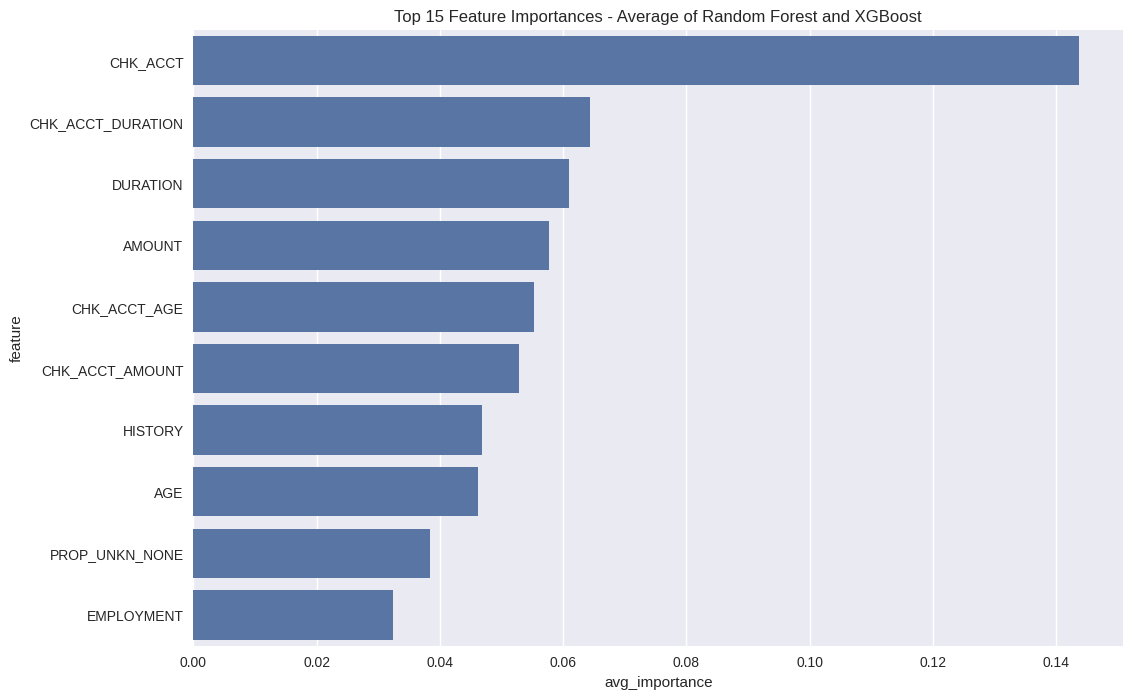

In [25]:
# Extract feature importances from Random Forest and XGBoost models
rf_importance = models['Random Forest'].feature_importances_
xgb_importance = models['XGBoost'].feature_importances_

# Create a DataFrame with combined feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_importance,
    'xgb_importance': xgb_importance
})

# Calculate average importance
feature_importance_df['avg_importance'] = (feature_importance_df['rf_importance'] + feature_importance_df['xgb_importance']) / 2

# Sort and select top 15 features
feature_importance_df = feature_importance_df.sort_values('avg_importance', ascending=False).head(10)
 
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_importance', y='feature', data=feature_importance_df)
plt.title('Top 15 Feature Importances - Average of Random Forest and XGBoost')
plt.show()

# 9. Conclusion and Next Steps
Based on our analysis and model evaluation, we have developed a predictive model to identify loan applicants with an acceptable probability of default. Despite making a model robust and generalized model, the Random Forest model performed the best with an ROC AUC score of 0.8307. 

## 9.1 Key findings:

- Model Performance: The Random Forest model outperformed other models, demonstrating the advantage of hyperparameter tuning.
- Imbalanced Dataset: The dataset is imbalanced, with about 70% non-default and 30% default cases, which posed challenges in model training and evaluation.
- Feature Importance: Random Forest and XGBoost identified the Checking account status and its combination with duration of credit in months as a key predictors of loan default by extracting feature importances.